In [2]:
import zipfile
import os
import pandas as pd

In [4]:
df_total = pd.read_csv("analise_pf_longoprazo.csv")
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8381 entries, 0 to 8380
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   8381 non-null   int64  
 1   data_base    8381 non-null   object 
 2   modalidade   8381 non-null   object 
 3   porte        8381 non-null   object 
 4   longo_prazo  8381 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 327.5+ KB


In [5]:
import deflatebr as dbr
nominal_values = df_total['longo_prazo']
nominal_dates = df_total['data_base']
real_date = '2023-08'

#criar uma coluna com o valor deflacionado
df_total['valor_deflacionado'] = dbr.deflate(nominal_values=nominal_values, nominal_dates=nominal_dates, real_date=real_date,
           index='ipca', progress_bar=True, on_jupyter=True)

  0%|          | 0/8381 [00:00<?, ?it/s]

C:\Users\USER\anaconda3\Lib\site-packages\deflatebr\deflate.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['deflated'] = df[['nom_values', 'VALVALOR']].progress_apply(lambda x: ((real_indx/x[1]) * x[0])[0], axis=1)


In [69]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   data_base           945 non-null    object 
 1   modalidade          945 non-null    object 
 2   valor_deflacionado  945 non-null    float64
dtypes: float64(1), object(2)
memory usage: 22.3+ KB


In [62]:
df_total['data_base'] = pd.to_datetime(df_total['data_base']).dt.strftime('%Y-%m')

In [63]:
# Importando a série do IPCA mensal (a)
#importa a bibliotaca
import requests

#define a url a ser usada
url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=json'
# fazendo a requisição à url e trazendo em formato json
inflacao_mensal = requests.get(url).json() 
#response é o nome da 'variável'. Pode ser qualquer outro nome

# visualizando os primeiros elementos da base
inflacao_mensal[500:505]

[{'data': '01/09/2021', 'valor': '1.16'},
 {'data': '01/10/2021', 'valor': '1.25'},
 {'data': '01/11/2021', 'valor': '0.95'},
 {'data': '01/12/2021', 'valor': '0.73'},
 {'data': '01/01/2022', 'valor': '0.54'}]

In [102]:
inflacao = pd.DataFrame(inflacao_mensal)

In [103]:
inflacao['data'] = pd.to_datetime(inflacao['data'], format = "%d/%m/%Y")

In [104]:
inflacao['data'] = inflacao['data'].dt.strftime('%Y-%m')

In [105]:
inflacao.head()

,data,valor
0,1980-01,6.62
1,1980-02,4.62
2,1980-03,6.04
3,1980-04,5.29
4,1980-05,5.70


In [107]:
inflacao.head()

,data,valor
0,1980-01,6.62
1,1980-02,4.62
2,1980-03,6.04
3,1980-04,5.29
4,1980-05,5.70


In [71]:
df_total['data_base'] = pd.to_datetime(df_total['data_base']).dt.strftime('%Y-%m')

In [77]:
df_inflacao_modalidade_agrupado = df_total.groupby(['data_base', 'modalidade'])['valor_deflacionado'].sum().reset_index()

In [109]:
df_inflacao_modalidade_agrupado =  pd.merge(inflacao,
                              df_inflacao_modalidade_agrupado,
                              left_on="data",
                              right_on="data_base",
                              how = "inner")

In [113]:
df_inflacao_modalidade_agrupado.head()

,data,valor,data_x,valor_x,data_y,valor_y,data_base,modalidade,valor_deflacionado
0,2013-01,0.86,2013-01,0.86,2013-01,0.86,2013-01,PF - Cartão de crédito,2312820705.18
1,2013-01,0.86,2013-01,0.86,2013-01,0.86,2013-01,PF - Empréstimo com consignação em folha,223866262381.75
2,2013-01,0.86,2013-01,0.86,2013-01,0.86,2013-01,PF - Empréstimo sem consignação em folha,72287723809.56
3,2013-01,0.86,2013-01,0.86,2013-01,0.86,2013-01,PF - Habitacional,409099151837.66
4,2013-01,0.86,2013-01,0.86,2013-01,0.86,2013-01,PF - Outros créditos,56645957404.80


In [87]:
import plotly.graph_objects as go

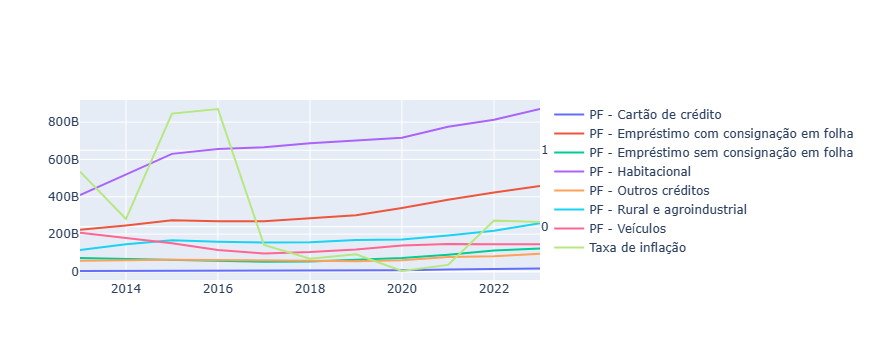

In [114]:
fig = go.Figure()

for modalidade in df_inflacao_modalidade_agrupado['modalidade'].unique():
    subset = df_inflacao_modalidade_agrupado[df_inflacao_modalidade_agrupado['modalidade'] == modalidade]
    fig.add_trace(go.Scatter(x=subset['data'],
                             y=subset['valor_deflacionado'],
                             mode='lines',
                             name=f'{modalidade}'))
    
# Adicionando a coluna 'valor' ao segundo eixo y
fig.add_trace(go.Scatter(x=df_inflacao_modalidade_agrupado['data'],
                         y=df_inflacao_modalidade_agrupado['valor'], 
                         mode='lines',
                         name='Taxa de inflação',
                         yaxis='y2'))

fig.update_layout(yaxis2=dict(overlaying='y',
                              side='right'))

fig.show()